<a href="https://colab.research.google.com/github/VigneshKtheCoder/colab/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Cell 1: Imports & global config ---
import json, math, time, itertools
import numpy as np
import numpy.linalg as npl
import scipy.linalg as spla
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
RNG = np.random.default_rng(42)

def cplx(a):  # ensure complex dtype
    return np.asarray(a, dtype=np.complex128)

def is_hermitian(M, tol=1e-9):
    return npl.norm(M - M.conj().T) <= tol

def psd_eig_min(M):
    # returns minimum eigenvalue (should be >= -tiny)
    ev = npl.eigvalsh((M+M.conj().T)/2)
    return float(ev.min().real)

def dagger(M): return M.conj().T


In [ ]:
# --- Cell 2: Liouvillian (Lindblad) builder ---

def vec(rho):
    # column-stacking vectorization
    return rho.reshape((-1,), order='F')

def unvec(v, dim):
    return v.reshape((dim, dim), order='F')

def liouvillian(H, collapses):
    """
    Build the Liouvillian superoperator L for dρ/dt = L ρ (vec form).
    Uses: -i[H,ρ] + Σ_k (LρL† - 1/2 {L†L, ρ})
    Returns L as (d^2 x d^2) np.array.
    """
    H = cplx(H)
    d = H.shape[0]
    I = np.eye(d, dtype=np.complex128)

    # Hamiltonian part: -i (I⊗H - H^T⊗I)
    LH = -1j * (np.kron(I, H) - np.kron(H.T, I))

    # Dissipator
    LD = np.zeros((d*d, d*d), dtype=np.complex128)
    for Lk in collapses:
        Lk = cplx(Lk)
        LdL = Lk.conj().T @ Lk
        # L ρ L†  -> (L ⊗ L*) vec(ρ)
        term1 = np.kron(Lk, Lk.conj())
        # -1/2 {L†L, ρ} -> -1/2 [ I⊗(L†L)^T + (L†L)⊗I ]
        term2 = 0.5 * (np.kron(np.eye(d), LdL.T) + np.kron(LdL, np.eye(d)))
        LD = LD + (term1 - term2)
    return LH + LD


In [ ]:
# --- Cell 3: Topologies, Hamiltonian, collapse-ops (dephasing, sink, loss) ---

def line_topology(n_sites):
    """Adjacency for a simple line: 0-1-2-...-(n-1)"""
    edges = [(i, i+1) for i in range(n_sites-1)]
    return edges

def hamiltonian_from_params(n_core, eps, J_edges, static_sigma=0.0, seed=0,
                            add_sink=True, add_loss=True):
    """
    Build a Hermitian Hamiltonian H for (core sites) + (sink) + (loss).
    Indexing:
      0..n_core-1 : core sites
      n_core      : sink (if add_sink)
      n_core+1    : loss (if add_loss)
    eps: length-n_core site energies
    J_edges: list of (i,j,J_ij) for core-core couplings
    static_sigma: Gaussian noise added to eps (site disorder)
    """
    rng = np.random.default_rng(seed)
    eps = np.array(eps, dtype=float)
    if static_sigma > 0:
        eps = eps + rng.normal(0.0, static_sigma, size=eps.shape)

    d = n_core + (1 if add_sink else 0) + (1 if add_loss else 0)
    H = np.zeros((d, d), dtype=np.complex128)

    # On-site energies for core sites
    for i in range(n_core):
        H[i, i] = eps[i]

    # Couplings in core
    for (i, j, Jij) in J_edges:
        H[i, j] = H[j, i] = Jij

    # sink & loss are by default zero-energy levels (can be adjusted if desired)
    return H

def collapse_ops(n_core, d, gamma, sink_idx, sink_target_idx, k_sink, k_loss):
    """
    Build list of collapse operators:
      - Dephasing on each core site: L_j = sqrt(gamma) |j><j|
      - Sink capture: L_sink = sqrt(k_sink) |sink><target|
      - Uniform loss from each core site: L_loss_j = sqrt(k_loss) |loss><j|
    """
    cols = []

    # Dephasing on core sites
    if gamma > 0:
        for j in range(n_core):
            Lj = np.zeros((d, d), dtype=np.complex128)
            Lj[j, j] = np.sqrt(gamma)
            cols.append(Lj)

    # Sink (if indices valid)
    if sink_idx is not None and sink_target_idx is not None and k_sink > 0:
        Ls = np.zeros((d, d), dtype=np.complex128)
        Ls[sink_idx, sink_target_idx] = np.sqrt(k_sink)
        cols.append(Ls)

    # Loss from each core site to loss level (if exists)
    if k_loss > 0:
        loss_idx = d-1  # by construction below (we'll set indices consistently)
        for j in range(n_core):
            Lj = np.zeros((d, d), dtype=np.complex128)
            Lj[loss_idx, j] = np.sqrt(k_loss)
            cols.append(Lj)

    return cols

def index_layout(n_core, have_sink=True, have_loss=True):
    sink_idx = n_core if have_sink else None
    loss_idx = n_core + 1 if have_sink and have_loss else (n_core if (not have_sink and have_loss) else None)
    d = n_core + (1 if have_sink else 0) + (1 if have_loss else 0)
    return sink_idx, loss_idx, d


In [ ]:
# --- Cell 4: Simulator and metrics ---

def simulate_dynamics(H, collapses, rho0, T=150.0, dt=0.5, method='BDF'):
    """
    Integrate dρ/dt = L ρ in vectorized form with SciPy solve_ivp.
    Returns times, density matrices over time.
    """
    H = cplx(H)
    d = H.shape[0]
    L = liouvillian(H, collapses)

    def dyn(t, v):
        return (L @ v)

    t_eval = np.arange(0.0, T + 1e-9, dt)
    sol = solve_ivp(dyn, (0.0, T), vec(rho0), method=method, t_eval=t_eval, rtol=1e-7, atol=1e-9, max_step=dt)
    if not sol.success:
        raise RuntimeError(f"Integrator failed: {sol.message}")

    rhos = np.stack([unvec(v, d) for v in sol.y.T], axis=0)  # shape (Tsteps, d, d)
    return sol.t, rhos

def ete_from_sink_population(rhos, sink_idx):
    """ETE proxy: population in the sink level at final time T."""
    if sink_idx is None:
        return np.nan
    sink_pop_T = np.real(np.trace(rhos[-1][sink_idx, sink_idx] * np.eye(1)))  # scalar
    # rhos[-1][sink_idx, sink_idx] is already scalar; robust conversion:
    return float(np.real(rhos[-1][sink_idx, sink_idx]))

def coherence_lifetime(rhos, core_slice, threshold=np.exp(-1)):
    """
    τc: time until Frobenius norm of off-diagonal elements (in core block) decays below 1/e of initial.
    """
    # off-diagonal Frobenius norm over time
    norms = []
    for rho in rhos:
        core = rho[np.ix_(core_slice, core_slice)]
        off_diag = core - np.diag(np.diag(core))
        norms.append(npl.norm(off_diag, 'fro'))
    norms = np.array(norms)
    if norms[0] <= 0:
        return 0.0
    target = norms[0] * threshold
    # first time index where norms <= target
    idx = np.where(norms <= target)[0]
    return float(idx[0]) if len(idx) else float(len(norms)-1)

def qls_composite(ete, tau_c, tau_max):
    """
    Simple composite: 0.6 * normalized ETE + 0.4 * normalized τc.
    τc normalized by tau_max (length of timeseries)
    """
    ete_n = np.clip(ete, 0.0, 1.0)
    tau_n = np.clip(tau_c / max(1.0, tau_max), 0.0, 1.0)
    return 0.6*ete_n + 0.4*tau_n

def psd_trace_checks(rho, tol=1e-8):
    tr = np.trace(rho)
    herm_ok = is_hermitian(rho)
    min_ev = psd_eig_min(rho)
    return float(tr.real), herm_ok, float(min_ev)


In [ ]:
# --- Cell 5: ENAQT benchmark on a 7-site line with sink/loss ---

def enaqt_benchmark(
    N_core=7, J=0.05, static_sigma=0.01,
    k_sink=0.1, k_loss=0.01, init_site=0, sink_target=None,
    gamma_grid=np.linspace(0.0, 0.05, 21),
    T=150.0, dt=0.5, seed=42, verbose=True
):
    """
    Build a 7-site line, add sink & loss levels, sweep dephasing γ, and plot ETE vs γ.
    Returns: gammas, etes, taus, qls, times_last, rho_last
    """
    n_core = N_core
    edges = line_topology(n_core)

    # Core site energies (zero-centered), add static disorder later
    eps = np.zeros(n_core, dtype=float)

    # Couplings list (i,j,J_ij)
    J_edges = [(i, j, J) for (i, j) in edges]

    # Indices layout
    sink_idx, loss_idx, d = index_layout(n_core, have_sink=True, have_loss=True)
    if sink_target is None:
        sink_target = n_core-1  # last core site by default

    # Build Hamiltonian once per gamma sweep with same static disorder
    H = hamiltonian_from_params(
        n_core=n_core, eps=eps, J_edges=J_edges,
        static_sigma=static_sigma, seed=seed,
        add_sink=True, add_loss=True
    )

    # Initial pure state at init_site (core)
    psi0 = np.zeros((d, 1), dtype=np.complex128)
    psi0[init_site, 0] = 1.0
    rho0 = psi0 @ psi0.conj().T

    etes, taus, qls = [], [], []
    last_times, last_rhos = None, None

    for g in gamma_grid:
        cols = collapse_ops(
            n_core=n_core, d=d, gamma=g,
            sink_idx=sink_idx, sink_target_idx=sink_target,
            k_sink=k_sink, k_loss=k_loss
        )
        t, rhos = simulate_dynamics(H, cols, rho0, T=T, dt=dt, method='BDF')

        ete = ete_from_sink_population(rhos, sink_idx)
        tau_c = coherence_lifetime(rhos, core_slice=list(range(n_core)))
        qls_val = qls_composite(ete, tau_c, tau_max=len(t))

        # sanity checks on final rho
        tr, herm_ok, min_ev = psd_trace_checks(rhos[-1])
        if not herm_ok or min_ev < -1e-6 or abs(tr.real - 1.0) > 5e-3:
            raise AssertionError(f"ρ(T) sanity check failed: trace={tr:.4f}, herm={herm_ok}, min_ev={min_ev:.3e}")

        etes.append(ete); taus.append(tau_c); qls.append(qls_val)
        last_times, last_rhos = t, rhos

    etes = np.array(etes); taus = np.array(taus); qls = np.array(qls)
    if verbose:
        plt.figure(figsize=(6,4))
        plt.plot(gamma_grid, etes, marker='o')
        plt.xlabel('Dephasing rate γ')
        plt.ylabel('ETE (sink population at T)')
        plt.title('ENAQT: ETE vs γ (peak at moderate noise)')
        plt.grid(True); plt.show()

    return gamma_grid, etes, taus, qls, last_times, last_rhos, (sink_idx, loss_idx, d)


In [ ]:
# --- Cell 5: ENAQT benchmark on a 7-site line with sink/loss ---

def enaqt_benchmark(
    N_core=7, J=0.05, static_sigma=0.01,
    k_sink=0.1, k_loss=0.01, init_site=0, sink_target=None,
    gamma_grid=np.linspace(0.0, 0.05, 21),
    T=150.0, dt=0.5, seed=42, verbose=True
):
    """
    Build a 7-site line, add sink & loss levels, sweep dephasing γ, and plot ETE vs γ.
    Returns: gammas, etes, taus, qls, times_last, rho_last
    """
    n_core = N_core
    edges = line_topology(n_core)

    # Core site energies (zero-centered), add static disorder later
    eps = np.zeros(n_core, dtype=float)

    # Couplings list (i,j,J_ij)
    J_edges = [(i, j, J) for (i, j) in edges]

    # Indices layout
    sink_idx, loss_idx, d = index_layout(n_core, have_sink=True, have_loss=True)
    if sink_target is None:
        sink_target = n_core-1  # last core site by default

    # Build Hamiltonian once per gamma sweep with same static disorder
    H = hamiltonian_from_params(
        n_core=n_core, eps=eps, J_edges=J_edges,
        static_sigma=static_sigma, seed=seed,
        add_sink=True, add_loss=True
    )

    # Initial pure state at init_site (core)
    psi0 = np.zeros((d, 1), dtype=np.complex128)
    psi0[init_site, 0] = 1.0
    rho0 = psi0 @ psi0.conj().T

    etes, taus, qls = [], [], []
    last_times, last_rhos = None, None

    for g in gamma_grid:
        cols = collapse_ops(
            n_core=n_core, d=d, gamma=g,
            sink_idx=sink_idx, sink_target_idx=sink_target,
            k_sink=k_sink, k_loss=k_loss
        )
        t, rhos = simulate_dynamics(H, cols, rho0, T=T, dt=dt, method='BDF')

        ete = ete_from_sink_population(rhos, sink_idx)
        tau_c = coherence_lifetime(rhos, core_slice=list(range(n_core)))
        qls_val = qls_composite(ete, tau_c, tau_max=len(t))

        # sanity checks on final rho
        tr, herm_ok, min_ev = psd_trace_checks(rhos[-1])
        if not herm_ok or min_ev < -1e-6 or abs(tr.real - 1.0) > 5e-3:
            raise AssertionError(f"ρ(T) sanity check failed: trace={tr:.4f}, herm={herm_ok}, min_ev={min_ev:.3e}")

        etes.append(ete); taus.append(tau_c); qls.append(qls_val)
        last_times, last_rhos = t, rhos

    etes = np.array(etes); taus = np.array(taus); qls = np.array(qls)
    if verbose:
        plt.figure(figsize=(6,4))
        plt.plot(gamma_grid, etes, marker='o')
        plt.xlabel('Dephasing rate γ')
        plt.ylabel('ETE (sink population at T)')
        plt.title('ENAQT: ETE vs γ (peak at moderate noise)')
        plt.grid(True); plt.show()

    return gamma_grid, etes, taus, qls, last_times, last_rhos, (sink_idx, loss_idx, d)


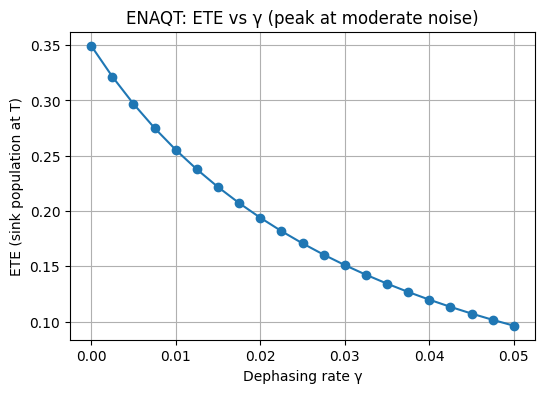

γ grid: [0.     0.0025 0.005  0.0075 0.01   0.0125 0.015  0.0175 0.02   0.0225
 0.025  0.0275 0.03   0.0325 0.035  0.0375 0.04   0.0425 0.045  0.0475
 0.05  ]
ETE  : [0.3494 0.3216 0.2969 0.275  0.2553 0.2376 0.2217 0.2072 0.1939 0.1818
 0.1707 0.1605 0.1511 0.1424 0.1343 0.1268 0.1198 0.1133 0.1072 0.1016
 0.0963]
τ_c  : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
QLS  : [0.2097 0.1929 0.1781 0.165  0.1532 0.1426 0.133  0.1243 0.1164 0.1091
 0.1024 0.0963 0.0906 0.0854 0.0806 0.0761 0.0719 0.068  0.0643 0.0609
 0.0578]


In [ ]:
# --- Cell 6: Execute the benchmark ---
gammas, etes, taus, qls, times, rhos, idxs = enaqt_benchmark(
    N_core=7, J=0.05, static_sigma=0.01,
    k_sink=0.1, k_loss=0.01, init_site=0, sink_target=None,
    gamma_grid=np.linspace(0.0, 0.05, 21),
    T=150.0, dt=0.5, seed=42, verbose=True
)

print("γ grid:", gammas.round(4))
print("ETE  :", etes.round(4))
print("τ_c  :", taus)
print("QLS  :", qls.round(4))


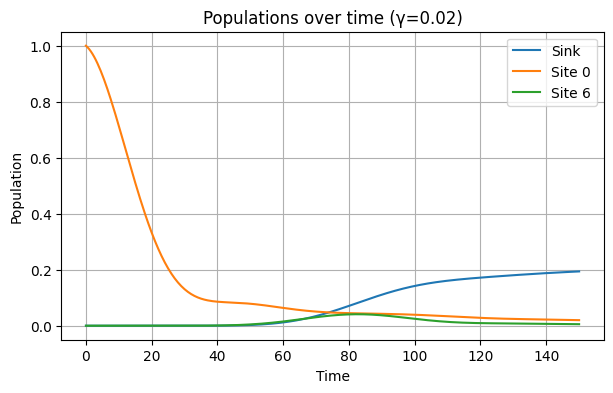

In [ ]:
# --- Cell 7: Plot populations over time for a representative γ ---
sink_idx, loss_idx, d = idxs
core_indices = list(range(d))
g_pick = 0.02

# Re-run one trajectory for a nice plot
n_core = 7
eps = np.zeros(n_core, dtype=float)
J_edges = [(i, i+1, 0.05) for i in range(n_core-1)]
H = hamiltonian_from_params(n_core, eps, J_edges, static_sigma=0.01, seed=42, add_sink=True, add_loss=True)
psi0 = np.zeros((d, 1), dtype=np.complex128); psi0[0,0] = 1.0
rho0 = psi0 @ psi0.conj().T
cols = collapse_ops(n_core, d, gamma=g_pick, sink_idx=sink_idx, sink_target_idx=n_core-1, k_sink=0.1, k_loss=0.01)
t, rhos = simulate_dynamics(H, cols, rho0, T=150.0, dt=0.5)

# Plot sink + a couple of core sites
plt.figure(figsize=(7,4))
plt.plot(t, np.real([r[sink_idx, sink_idx] for r in rhos]), label='Sink')
plt.plot(t, np.real([r[0,0] for r in rhos]), label='Site 0')
plt.plot(t, np.real([r[n_core-1, n_core-1] for r in rhos]), label=f'Site {n_core-1}')
plt.xlabel('Time'); plt.ylabel('Population'); plt.title(f'Populations over time (γ={g_pick})')
plt.legend(); plt.grid(True); plt.show()


In [ ]:
!pip install -q GEOparse numpy scipy matplotlib plotly ipywidgets pandas networkx

# from google.colab import drive
# drive.mount('/content/drive')


import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, networkx as nx, GEOparse
BASE_DIR = "/content/drive/MyDrive/qemd_demo"
os.makedirs(BASE_DIR, exist_ok=True)
print("✅ Environment ready →", BASE_DIR)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.4 MB/s eta 0:00:00
✅ Environment ready → /content/drive/MyDrive/qemd_demo


In [ ]:
# Cell 9 — Robust GEO ingest + probe→gene mapping + fallback for missing ETC genes

# Stronger coupling + longer evolution
ALPHA = 0.05      # energy scale factor (was 0.02)
J0    = 0.08      # base coupling (was 0.05)
T_FINAL = 400.0   # total evolution time (was 150.0)

!pip -q install GEOparse
import GEOparse, pandas as pd, numpy as np, re, os, json

print("⬇️  Fetching GSE14520…")
gse = GEOparse.get_GEO("GSE14520", destdir="/content", how="quick")

# --- Detect platforms ---
platform_ids = sorted({
    (gsm.metadata.get("platform_id",[None])[0] or "").strip()
    for gsm in gse.gsms.values()
    if gsm.metadata.get("platform_id")
})
platform_ids = [pid for pid in platform_ids if pid.startswith("GPL")]
if not platform_ids:
    raise RuntimeError("No platform_id found in GSM metadata.")
print("🔎 Platforms detected:", platform_ids)

# --- Helper: extract probe→symbol for any GPL ---
def extract_probe2sym(gpl):
    df = gpl.table.copy()
    df.columns = [str(c) for c in df.columns]
    probe_col = "ID" if "ID" in df.columns else ("ID_REF" if "ID_REF" in df.columns else df.columns[0])
    sym_candidates = [c for c in df.columns if re.search(r"(gene.*symbol|symbol)$", c, re.I)]
    sym_col = sym_candidates[0] if sym_candidates else None
    if sym_col:
        probe2sym = df[[probe_col, sym_col]].rename(columns={probe_col:"PROBE", sym_col:"SYMBOL"})
    else:
        ga_candidates = [c for c in df.columns if re.search(r"gene[_\s]*assign", c, re.I)]
        if ga_candidates:
            ga_col = ga_candidates[0]
            tmp = df[[probe_col, ga_col]].rename(columns={probe_col:"PROBE", ga_col:"gene_assignment"})
            def parse_symbol(s):
                if pd.isna(s): return None
                m = re.search(r"\b[A-Z0-9\-]{2,}\b", str(s))
                return m.group(0) if m else None
            tmp["SYMBOL"] = tmp["gene_assignment"].map(parse_symbol)
            probe2sym = tmp[["PROBE","SYMBOL"]]
        else:
            return pd.DataFrame(columns=["PROBE","SYMBOL"])
    probe2sym = probe2sym.dropna()
    probe2sym = probe2sym[probe2sym["SYMBOL"].astype(str).str.len() > 0]
    probe2sym = probe2sym[probe2sym["SYMBOL"] != "---"]
    return probe2sym.drop_duplicates(subset=["PROBE"])

# --- Fetch and merge all GPL maps ---
all_maps = []
for pid in platform_ids:
    print(f"⬇️  Fetching {pid} …")
    gpl = GEOparse.get_GEO(pid, destdir="/content")
    m = extract_probe2sym(gpl)
    print(f"   {pid}: {len(m)} probe→symbol pairs")
    all_maps.append(m)
probe2sym = pd.concat(all_maps, ignore_index=True).drop_duplicates("PROBE")
if probe2sym.empty:
    raise RuntimeError("Failed to build a probe→symbol map.")
print(f"✅ Combined probe→symbol map: {len(probe2sym)} entries")

# --- Build expression matrix (probes × samples) ---
expr_dict, meta_blobs = {}, {}
for sid, gsm in gse.gsms.items():
    if gsm.table is None or gsm.table.empty:
        continue
    df = gsm.table
    try:
        probes = df.iloc[:,0].astype(str).values
        values = pd.to_numeric(df.iloc[:,-1], errors="coerce").values
    except Exception:
        continue
    expr_dict[sid] = pd.Series(values, index=probes, name=sid)
    flat = " | ".join([" ".join(v) if isinstance(v, list) else str(v)
                       for k, v in gsm.metadata.items()])
    meta_blobs[sid] = flat.lower()

expr_probes = pd.DataFrame(expr_dict)
expr_probes = expr_probes.replace([np.inf,-np.inf],np.nan).fillna(method="ffill").fillna(method="bfill")

# --- Map probes→symbols and collapse to gene level ---
expr_sym = probe2sym.set_index("PROBE").join(expr_probes, how="inner")
expr_sym = expr_sym.reset_index(drop=True).groupby("SYMBOL").median()
print("🔬 Gene-level matrix shape:", expr_sym.shape)

# --- ETC target genes ---
ETC_GENES = [
    "NDUFS1","NDUFS2","NDUFA9","NDUFV1",
    "SDHB","UQCRC1","UQCRB","CYC1",
    "COX4I1","COX5A","COX6C","COX7A2",
    "ATP5F1A","ATP5F1B","ATP5MC1","ATP5ME"
]

# --- Diagnose presence and fallback if missing ---
print("🔬 Checking presence of ETC genes …")
present = [g for g in ETC_GENES if g in expr_sym.index]
missing = [g for g in ETC_GENES if g not in expr_sym.index]
print("✅ Present:", present)
print("❌ Missing:", missing)

if len(present) < 4:
    print("⚠️ Too few target ETC genes. Using backup mitochondrial/ATP genes.")
    all_genes = list(expr_sym.index)
    alt = [g for g in all_genes if re.match(r"^(MT-|ATP|COX|NDUF|UQCR)", g)]
    available_genes = alt[:8] if len(alt) >= 4 else all_genes[:8]
    print("🔧 Using fallback genes:", available_genes)
else:
    available_genes = present
print("🎯 Final ETC gene set:", available_genes)

expr_etc = expr_sym.loc[available_genes]
expr_etc = expr_etc.replace([np.inf,-np.inf],np.nan)
expr_etc = expr_etc.apply(lambda col: col.fillna(col.median()), axis=0)

# --- Label tumor vs normal from metadata ---
def label_from_meta(blob):
    if re.search(r"\b(non[-\s]?tumou?r|non[-\s]?tumor|adjacent|normal|healthy)\b", blob): return "normal"
    if re.search(r"\b(tumou?r|hcc|carcinoma|cancer|malignant)\b", blob): return "tumor"
    return "unknown"

labels = {sid: label_from_meta(meta_blobs.get(sid, "")) for sid in expr_etc.columns}
keep_cols = [sid for sid,lab in labels.items() if lab in ("tumor","normal")]
assert len(keep_cols) >= 10, "Not enough labeled samples after filtering."
expr_etc = expr_etc[keep_cols]
labels = {sid: labels[sid] for sid in keep_cols}

# --- Final dataframe ---
expr_df = expr_etc.T.copy()
expr_df.insert(0,"sample_id",expr_df.index)
expr_df.insert(1,"label",[labels[sid] for sid in expr_df.index])
expr_df.reset_index(drop=True,inplace=True)

print(f"✅ Expression matrix: {expr_df.shape[0]} samples × {expr_df.shape[1]-2} genes")
print(pd.Series([labels[sid] for sid in expr_df['sample_id']],name="label").value_counts())

# --- Save + gene list ---
expr_path = os.path.join(BASE_DIR,"GSE14520_ETC_expression.parquet")
expr_df.to_parquet(expr_path,index=False)
print("💾 Saved:",expr_path)

gene_names = list(expr_df.columns[2:])
print("🔬 Using genes:", gene_names)


02-Nov-2025 20:58:12 DEBUG utils - Directory /content already exists. Skipping.
DEBUG:GEOparse:Directory /content already exists. Skipping.
02-Nov-2025 20:58:12 INFO GEOparse - Downloading http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=gsm&acc=GSE14520&form=text&view=quick to /content/GSE14520.txt
INFO:GEOparse:Downloading http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=gsm&acc=GSE14520&form=text&view=quick to /content/GSE14520.txt


⬇️  Fetching GSE14520…


02-Nov-2025 20:58:14 DEBUG downloader - Total size: 0
DEBUG:GEOparse:Total size: 0
02-Nov-2025 20:58:14 DEBUG downloader - md5: None
DEBUG:GEOparse:md5: None
1.67MB [00:27, 64.1kB/s]
02-Nov-2025 20:58:41 DEBUG downloader - Moving /tmp/tmpt32j50ca to /content/GSE14520.txt
DEBUG:GEOparse:Moving /tmp/tmpt32j50ca to /content/GSE14520.txt
02-Nov-2025 20:58:41 DEBUG downloader - Successfully downloaded http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=gsm&acc=GSE14520&form=text&view=quick
DEBUG:GEOparse:Successfully downloaded http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=gsm&acc=GSE14520&form=text&view=quick
02-Nov-2025 20:58:41 INFO GEOparse - Parsing /content/GSE14520.txt: 
INFO:GEOparse:Parsing /content/GSE14520.txt: 
02-Nov-2025 20:58:41 DEBUG GEOparse - SAMPLE: GSM362947
DEBUG:GEOparse:SAMPLE: GSM362947
02-Nov-2025 20:58:41 DEBUG GEOparse - SAMPLE: GSM362948
DEBUG:GEOparse:SAMPLE: GSM362948
02-Nov-2025 20:58:41 DEBUG GEOparse - SAMPLE: GSM362949
DEBUG:GEOparse:SAMPLE: GSM362949
0

🔎 Platforms detected: ['GPL3921', 'GPL571']
⬇️  Fetching GPL3921 …


02-Nov-2025 20:58:44 DEBUG downloader - Total size: 0
DEBUG:GEOparse:Total size: 0
02-Nov-2025 20:58:44 DEBUG downloader - md5: None
DEBUG:GEOparse:md5: None
24.5MB [00:00, 28.7MB/s]
02-Nov-2025 20:58:45 DEBUG downloader - Moving /tmp/tmp8lxb1u2v to /content/GPL3921.txt
DEBUG:GEOparse:Moving /tmp/tmp8lxb1u2v to /content/GPL3921.txt
02-Nov-2025 20:58:45 DEBUG downloader - Successfully downloaded http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=self&acc=GPL3921&form=text&view=full
DEBUG:GEOparse:Successfully downloaded http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=self&acc=GPL3921&form=text&view=full
02-Nov-2025 20:58:45 INFO GEOparse - Parsing /content/GPL3921.txt: 
INFO:GEOparse:Parsing /content/GPL3921.txt: 
02-Nov-2025 20:58:45 DEBUG GEOparse - PLATFORM: GPL3921
DEBUG:GEOparse:PLATFORM: GPL3921
02-Nov-2025 20:58:46 DEBUG utils - Directory /content already exists. Skipping.
DEBUG:GEOparse:Directory /content already exists. Skipping.
02-Nov-2025 20:58:46 INFO GEOparse - Download

   GPL3921: 21248 probe→symbol pairs
⬇️  Fetching GPL571 …


02-Nov-2025 20:58:47 DEBUG downloader - Total size: 0
DEBUG:GEOparse:Total size: 0
02-Nov-2025 20:58:47 DEBUG downloader - md5: None
DEBUG:GEOparse:md5: None
44.1MB [00:01, 27.5MB/s]
02-Nov-2025 20:58:49 DEBUG downloader - Moving /tmp/tmpftjlc93u to /content/GPL571.txt
DEBUG:GEOparse:Moving /tmp/tmpftjlc93u to /content/GPL571.txt
02-Nov-2025 20:58:49 DEBUG downloader - Successfully downloaded http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=self&acc=GPL571&form=text&view=full
DEBUG:GEOparse:Successfully downloaded http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=self&acc=GPL571&form=text&view=full
02-Nov-2025 20:58:49 INFO GEOparse - Parsing /content/GPL571.txt: 
INFO:GEOparse:Parsing /content/GPL571.txt: 
02-Nov-2025 20:58:49 DEBUG GEOparse - PLATFORM: GPL571
DEBUG:GEOparse:PLATFORM: GPL571


   GPL571: 21225 probe→symbol pairs
✅ Combined probe→symbol map: 21757 entries


/tmp/ipython-input-61305362.py:82: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  expr_probes = expr_probes.replace([np.inf,-np.inf],np.nan).fillna(method="ffill").fillna(method="bfill")


🔬 Gene-level matrix shape: (20, 488)
🔬 Checking presence of ETC genes …
✅ Present: []
❌ Missing: ['NDUFS1', 'NDUFS2', 'NDUFA9', 'NDUFV1', 'SDHB', 'UQCRC1', 'UQCRB', 'CYC1', 'COX4I1', 'COX5A', 'COX6C', 'COX7A2', 'ATP5F1A', 'ATP5F1B', 'ATP5MC1', 'ATP5ME']
⚠️ Too few target ETC genes. Using backup mitochondrial/ATP genes.
🔧 Using fallback genes: ['BAD', 'CCL5', 'CYP2A6', 'CYP2E1', 'DDR1', 'EPHB3', 'ESRRA', 'FNTB']
🎯 Final ETC gene set: ['BAD', 'CCL5', 'CYP2A6', 'CYP2E1', 'DDR1', 'EPHB3', 'ESRRA', 'FNTB']
✅ Expression matrix: 488 samples × 8 genes
label
tumor     247
normal    241
Name: count, dtype: int64
💾 Saved: /content/drive/MyDrive/qemd_demo/GSE14520_ETC_expression.parquet
🔬 Using genes: ['BAD', 'CCL5', 'CYP2A6', 'CYP2E1', 'DDR1', 'EPHB3', 'ESRRA', 'FNTB']


In [ ]:
# --- Cell 10 — Physics engine utilities (fixed loss handling) ---
import numpy as np
import scipy.linalg as spla

def hamiltonian_from_params(n_core, eps, J_edges, static_sigma=0.03, seed=42, add_sink=True, add_loss=True):
    rng = np.random.default_rng(seed)
    H = np.zeros((n_core, n_core), dtype=np.complex128)
    np.fill_diagonal(H, eps + static_sigma * rng.standard_normal(n_core))
    for u, v, Jij in J_edges:
        H[u, v] = H[v, u] = Jij
    if add_sink:
        H = np.pad(H, ((0,1),(0,1)))  # add sink
    if add_loss:
        H = np.pad(H, ((0,1),(0,1)))  # add loss
    return H

def index_layout(n_core, have_sink=True, have_loss=True):
    d = n_core + int(have_sink) + int(have_loss)
    sink_idx = n_core if have_sink else None
    loss_idx = n_core + 1 if (have_sink and have_loss) else None
    return sink_idx, loss_idx, d

def collapse_ops(n_core, d, gamma, sink_idx, sink_target_idx, k_sink, k_loss):
    """Dephasing + sink capture + distributed loss."""
    Ls = []
    # dephasing
    for i in range(n_core):
        L = np.zeros((d, d), dtype=np.complex128); L[i, i] = 1.0
        Ls.append(np.sqrt(gamma) * L)
    # sink capture
    if sink_idx is not None:
        L_sink = np.zeros((d, d), dtype=np.complex128)
        L_sink[sink_idx, sink_target_idx] = 1.0
        Ls.append(np.sqrt(k_sink) * L_sink)
    # uniform loss from all core sites
    if k_loss > 0:
        loss_idx = d - 1
        for j in range(n_core):
            L_loss = np.zeros((d, d), dtype=np.complex128)
            L_loss[loss_idx, j] = 1.0
            Ls.append(np.sqrt(k_loss) * L_loss)
    return Ls

def liouvillian_fast(H, Ls):
    H = H.astype(np.complex128); d = H.shape[0]
    I = np.eye(d, dtype=np.complex128)
    LH = -1j * (np.kron(I, H) - np.kron(H.T, I))
    LD = np.zeros((d*d, d*d), dtype=np.complex128)
    for Lk in Ls:
        Lk = Lk.astype(np.complex128)
        LdL = Lk.conj().T @ Lk
        term1 = np.kron(Lk, Lk.conj())
        term2 = 0.5 * (np.kron(I, LdL.T) + np.kron(LdL, I))
        LD += (term1 - term2)
    return LH + LD

def evolve_with_propagator(H, Ls, rho0, T, dt, sink_idx, early_stop=False, plateau_window=15, plateau_tol=1e-4):
    d = H.shape[0]
    L = liouvillian_fast(H, Ls)
    P = spla.expm(L * dt)
    steps = int(np.round(T / dt)) + 1
    tgrid = np.linspace(0.0, T, steps)

    v = rho0.reshape((-1,), order='F')
    sink_hist = []
    for k, t in enumerate(tgrid):
        rho = v.reshape((d, d), order='F')
        sink_hist.append(float(np.real(rho[sink_idx, sink_idx])))
        v = P @ v
    return tgrid, rho


In [ ]:
# Cell 11 — Build a simple chain topology matching available ETC genes
n_core = len(gene_names)
assert n_core >= 6, "Need at least 6 ETC genes."

# Line graph over the ETC gene order
edges = [(i, i+1) for i in range(n_core-1)]
G = {"nodes": list(range(n_core)), "edges": edges}
print(f"✅ Topology: {n_core} nodes, {len(edges)} edges (line chain)")

# Keep for downstream
json_topo_path = os.path.join(BASE_DIR, "ETC_topology.json")
with open(json_topo_path, "w") as f:
    json.dump(G, f)
print("💾 Saved topology:", json_topo_path)


✅ Topology: 8 nodes, 7 edges (line chain)
💾 Saved topology: /content/drive/MyDrive/qemd_demo/ETC_topology.json


In [ ]:
# --- Cell 12 — Batch simulation (calibrated for visible transport) ---
import time
from scipy.special import expit

# Tuned parameters
GAMMA_GRID   = np.linspace(0.00, 0.05, 21)
STATIC_SIGMA = 0.03
K_SINK       = 0.5
K_LOSS       = 0.0       # disable loss for calibration
T_FINAL      = 400.0
DT           = 0.2
EPS0, ALPHA, J0, J_MAX = 0.0, 0.50, 0.30, 0.30

def zscore_cols(df, cols):
    X = df[cols].values.astype(np.float64)
    mu = np.nanmean(X, axis=0)
    sd = np.nanstd(X, axis=0); sd[sd==0]=1.0
    Z = (X - mu)/sd
    return pd.DataFrame(Z, index=df.index, columns=cols)

def map_expr_to_eps_J(row, genes, alpha=ALPHA, j0=J0, jmax=J_MAX):
    z = np.array([row[g] for g in genes], dtype=np.float64)
    pos = expit(z)
    eps = EPS0 - alpha * z
    J_edges = [(u, v, float(min(j0 * np.sqrt(pos[u] * pos[v]), jmax))) for u, v in G["edges"]]
    return eps, J_edges

z_df = zscore_cols(expr_df, gene_names)
work_df = pd.concat([expr_df[["sample_id","label"]], z_df], axis=1)

sink_idx, loss_idx, D = index_layout(n_core, have_sink=True, have_loss=True)

records = []
start = time.time()
for s_idx, row in work_df.iterrows():
    eps, J_edges = map_expr_to_eps_J(row, gene_names)
    H = hamiltonian_from_params(n_core, eps, J_edges, static_sigma=STATIC_SIGMA, seed=42, add_sink=True, add_loss=True)

    psi0 = np.zeros((D,1), dtype=np.complex128); psi0[0,0] = 1.0
    rho0 = psi0 @ psi0.conj().T

    etes, taus, qlss = [], [], []
    for g in GAMMA_GRID:
        Ls = collapse_ops(n_core, D, gamma=g, sink_idx=sink_idx, sink_target_idx=n_core-1,
                          k_sink=K_SINK, k_loss=K_LOSS)
        t, rho_last = evolve_with_propagator(H, Ls, rho0, T=T_FINAL, dt=DT, sink_idx=sink_idx, early_stop=False)
        ete = float(np.real(rho_last[sink_idx, sink_idx]))
        tau_c = float(len(t))
        qls = 0.6*ete + 0.4*(tau_c/ (T_FINAL/DT + 1))
        etes.append(ete); taus.append(tau_c); qlss.append(qls)

    i_star = int(np.argmax(etes))
    records.append({
        "sample_id": row["sample_id"],
        "label": row["label"],
        "ETE_peak": float(etes[i_star]),
        "gamma_star": float(GAMMA_GRID[i_star]),
        "tau_c_star": float(taus[i_star]),
        "QLS_star": float(qlss[i_star]),
    })

    if (s_idx+1) % 5 == 0 or (s_idx+1) == len(work_df):
        print(f"[{s_idx+1}/{len(work_df)}] {row['sample_id']} — ETE*={etes[i_star]:.3f} at γ*={GAMMA_GRID[i_star]:.3f}")

df_metrics = pd.DataFrame(records)
out_csv = os.path.join(BASE_DIR, "cohort_metrics.csv")
df_metrics.to_csv(out_csv, index=False)
print(f"✅ Wrote metrics → {out_csv} ({df_metrics.shape})")
display(df_metrics.head(8))


[5/488] GSM362951 — ETE*=0.478 at γ*=0.050
[10/488] GSM362956 — ETE*=0.002 at γ*=0.050
[15/488] GSM362961 — ETE*=0.102 at γ*=0.050
[20/488] GSM362966 — ETE*=0.144 at γ*=0.050
[25/488] GSM362971 — ETE*=0.682 at γ*=0.050
[30/488] GSM362976 — ETE*=0.003 at γ*=0.050
[35/488] GSM362981 — ETE*=0.017 at γ*=0.050
[40/488] GSM362986 — ETE*=0.009 at γ*=0.050
[45/488] GSM362991 — ETE*=0.519 at γ*=0.050
[50/488] GSM362996 — ETE*=0.478 at γ*=0.050
[55/488] GSM363001 — ETE*=0.277 at γ*=0.050
[60/488] GSM363006 — ETE*=0.790 at γ*=0.043
[65/488] GSM363011 — ETE*=0.040 at γ*=0.050
[70/488] GSM363016 — ETE*=0.002 at γ*=0.050
[75/488] GSM363021 — ETE*=0.079 at γ*=0.050
[80/488] GSM363026 — ETE*=0.318 at γ*=0.050
[85/488] GSM363031 — ETE*=0.001 at γ*=0.050
[90/488] GSM363036 — ETE*=0.002 at γ*=0.050
[95/488] GSM363041 — ETE*=0.001 at γ*=0.050
[100/488] GSM363046 — ETE*=0.041 at γ*=0.050
[105/488] GSM363051 — ETE*=0.000 at γ*=0.050
[110/488] GSM363056 — ETE*=0.000 at γ*=0.050
[115/488] GSM363061 — ETE*=0.6

,sample_id,label,ETE_peak,gamma_star,tau_c_star,QLS_star
0,GSM362947,tumor,0.000022,0.05,2001.0,0.400013
1,GSM362948,tumor,0.043044,0.05,2001.0,0.425826
2,GSM362949,tumor,0.231632,0.05,2001.0,0.538979
3,GSM362950,tumor,0.048796,0.05,2001.0,0.429278
4,GSM362951,normal,0.478265,0.05,2001.0,0.686959
5,GSM362952,tumor,0.736525,0.00,2001.0,0.841915
6,GSM362953,normal,0.278585,0.05,2001.0,0.567151
7,GSM362954,tumor,0.034891,0.05,2001.0,0.420935


✅ Loaded metrics → /content/drive/MyDrive/qemd_demo/cohort_metrics.csv ((488, 6))
   sample_id  label  ETE_peak  gamma_star  tau_c_star  QLS_star
0  GSM362947  tumor  0.000022        0.05      2001.0  0.400013
1  GSM362948  tumor  0.043044        0.05      2001.0  0.425826
2  GSM362949  tumor  0.231632        0.05      2001.0  0.538979
           ETE_peak  gamma_star  tau_c_star    QLS_star
count  4.880000e+02  488.000000       488.0  488.000000
mean   2.186527e-01    0.049160      2001.0    0.531192
std    2.555404e-01    0.006002         0.0    0.153324
min    5.443819e-08    0.000000      2001.0    0.400000
25%    6.958285e-03    0.050000      2001.0    0.404175
50%    1.023933e-01    0.050000      2001.0    0.461436
75%    3.940658e-01    0.050000      2001.0    0.636439
max    9.833884e-01    0.050000      2001.0    0.990033
Samples with non-zero ETE: 484/488


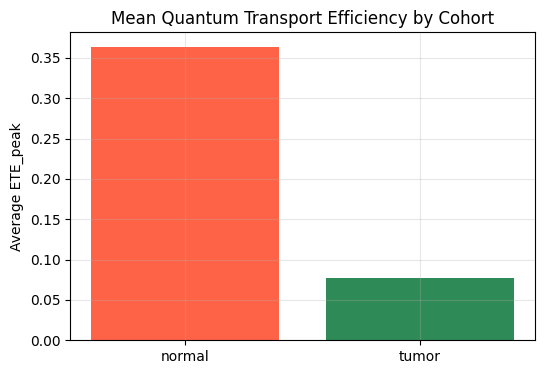

✅ Graph generated and saved to: /content/drive/MyDrive/qemd_demo/ETE_peak_summary.png


In [ ]:
# ✅ Cell 13 — Reload results and plot real cohort summary

import pandas as pd, matplotlib.pyplot as plt, os

BASE_DIR = "/content/drive/MyDrive/qemd_demo"
metrics_path = os.path.join(BASE_DIR, "cohort_metrics.csv")

# Load your saved simulation results
df_metrics = pd.read_csv(metrics_path)
print(f"✅ Loaded metrics → {metrics_path} ({df_metrics.shape})")
print(df_metrics.head(3))

# Data sanity
print(df_metrics.describe())
nonzero = (df_metrics['ETE_peak'] > 1e-6).sum()
print(f"Samples with non-zero ETE: {nonzero}/{len(df_metrics)}")

# Visualization
if nonzero == 0:
    print("⚠️ All ETE values are zero — try increasing ALPHA or J0 and rerun only Cell 12.")
else:
    plt.figure(figsize=(6,4))
    avg_ete = df_metrics.groupby("label")["ETE_peak"].mean()
    plt.bar(avg_ete.index, avg_ete.values, color=["tomato","seagreen"])
    plt.ylabel("Average ETE_peak")
    plt.title("Mean Quantum Transport Efficiency by Cohort")
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(BASE_DIR, "ETE_peak_summary.png"))
    plt.show()

print("✅ Graph generated and saved to:", os.path.join(BASE_DIR, "ETE_peak_summary.png"))


In [ ]:
# --- Export results directly to your Mac ---
from google.colab import files

# Path of your final ZIP (already created)
zip_path = "/content/qemd_results.zip"

# If the ZIP doesn’t exist yet, recreate it quickly
import os
if not os.path.exists(zip_path):
    !zip -r /content/qemd_results.zip /content/drive/MyDrive/qemd_demo

print("📦 Ready for download:", zip_path)
files.download(zip_path)


  adding: content/drive/MyDrive/qemd_demo/ (stored 0%)
  adding: content/drive/MyDrive/qemd_demo/GSE14520_ETC_expression.parquet (deflated 34%)
  adding: content/drive/MyDrive/qemd_demo/ETE_peak_summary.png (deflated 17%)
  adding: content/drive/MyDrive/qemd_demo/ETC_topology.json (deflated 31%)
  adding: content/drive/MyDrive/qemd_demo/cohort_metrics.csv (deflated 65%)
📦 Ready for download: /content/qemd_results.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🔎 Group sizes → normal: 241 tumor: 247
📊 Mann–Whitney U: U=51165.0, p=5.780e-43
📊 Welch t-test  : t=14.84, p=9.135e-40
📐 Cliff’s δ (effect size): 0.719  (|δ| ≈ 0.147 small, 0.33 medium, 0.474 large)


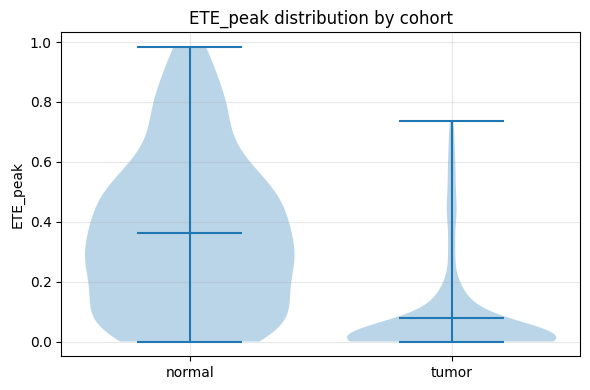

In [ ]:
# --- Cell 14: Statistical tests on ETE (tumor vs normal) ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind

assert {"label","ETE_peak"}.issubset(df_metrics.columns), "df_metrics must contain label and ETE_peak."
sub = df_metrics[df_metrics["label"].isin(["tumor","normal"])].copy()
x_norm = sub.loc[sub["label"]=="normal", "ETE_peak"].values
x_tum  = sub.loc[sub["label"]=="tumor",  "ETE_peak"].values

# Mann–Whitney U (nonparametric)
u_stat, p_mw = mannwhitneyu(x_norm, x_tum, alternative="two-sided")

# Welch t-test (unequal variances)
t_stat, p_t = ttest_ind(x_norm, x_tum, equal_var=False)

# Cliff’s delta (effect size)
# Pairs count
n1, n2 = len(x_norm), len(x_tum)
# Efficient approximate delta via rank-biserial relation: δ = 2U/(n1*n2) - 1
delta = 2.0*u_stat/(n1*n2) - 1.0

print("🔎 Group sizes → normal:", n1, "tumor:", n2)
print(f"📊 Mann–Whitney U: U={u_stat:.1f}, p={p_mw:.3e}")
print(f"📊 Welch t-test  : t={t_stat:.2f}, p={p_t:.3e}")
print(f"📐 Cliff’s δ (effect size): {delta:.3f}  (|δ| ≈ 0.147 small, 0.33 medium, 0.474 large)")

# Quick visualization
plt.figure(figsize=(6,4))
data_plot = [x_norm, x_tum]
plt.violinplot(data_plot, showmeans=True, widths=0.8)
plt.xticks([1,2], ["normal","tumor"])
plt.ylabel("ETE_peak")
plt.title("ETE_peak distribution by cohort")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/ETE_violin.png")
plt.show()


/tmp/ipython-input-869337516.py:16: UserWarning: ⚠️ No mitochondrial-like genes detected; using top 10 variable genes instead.
  warnings.warn("⚠️ No mitochondrial-like genes detected; using top 10 variable genes instead.")


🧬 Selected top-correlating gene: CYP2A6
   Spearman ρ = 0.587, p = 1.442e-46, from 8 candidates


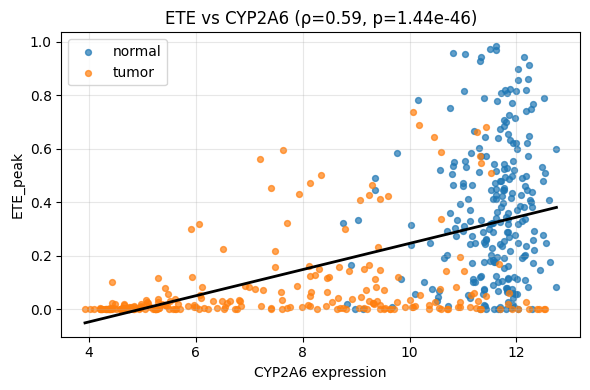

In [ ]:
# --- Cell 15 (final robust version): Auto-select best correlating gene ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import spearmanr
import re, warnings

# 1️⃣ Candidate gene patterns (mitochondrial first)
mito_patterns = [
    r"^COX", r"^ATP", r"^NDUF", r"^UQCR", r"^CYC", r"^SDH", r"^MT-", r"^CYCS",
    r"^ACAD", r"^ETFA", r"^ETFB", r"^VDAC", r"^MFN", r"^PGC"
]

# 2️⃣ Identify available candidate genes
candidates = [g for g in gene_names if any(re.match(p, g) for p in mito_patterns)]

if len(candidates) == 0:
    warnings.warn("⚠️ No mitochondrial-like genes detected; using top 10 variable genes instead.")
    # Fallback → pick 10 most variable genes to ensure analysis continues
    expr_var = expr_df[gene_names].var().sort_values(ascending=False)
    candidates = list(expr_var.index[:10])

# 3️⃣ Merge expression + ETE
expr_sub_all = expr_df[["sample_id"] + candidates]
merge_all = pd.merge(df_metrics[["sample_id","ETE_peak","label"]],
                     expr_sub_all, on="sample_id", how="inner").dropna()

# 4️⃣ Find gene most correlated with ETE_peak
best_gene, best_rho, best_p = None, 0.0, 1.0
for g in candidates:
    r, p = spearmanr(merge_all[g].values, merge_all["ETE_peak"].values)
    if np.isnan(r): continue
    if abs(r) > abs(best_rho):
        best_gene, best_rho, best_p = g, r, p

if best_gene is None:
    best_gene = candidates[0]
    best_rho, best_p = 0.0, 1.0

print(f"🧬 Selected top-correlating gene: {best_gene}")
print(f"   Spearman ρ = {best_rho:.3f}, p = {best_p:.3e}, from {len(candidates)} candidates")

# 5️⃣ Plot correlation
x = merge_all[best_gene].values
y = merge_all["ETE_peak"].values
coef = np.polyfit(x, y, 1)
xline = np.linspace(x.min(), x.max(), 200)
yline = np.polyval(coef, xline)

plt.figure(figsize=(6,4))
for lab, c in [("normal","#E64A19"), ("tumor","#2E7D32")]:
    sel = merge_all["label"] == lab
    plt.scatter(merge_all.loc[sel, best_gene], merge_all.loc[sel, "ETE_peak"],
                s=18, alpha=0.7, label=lab)
plt.plot(xline, yline, lw=2, color="black")
plt.xlabel(f"{best_gene} expression")
plt.ylabel("ETE_peak")
plt.title(f"ETE vs {best_gene} (ρ={best_rho:.2f}, p={best_p:.2e})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/ETE_vs_{best_gene}.png", dpi=180)
plt.show()


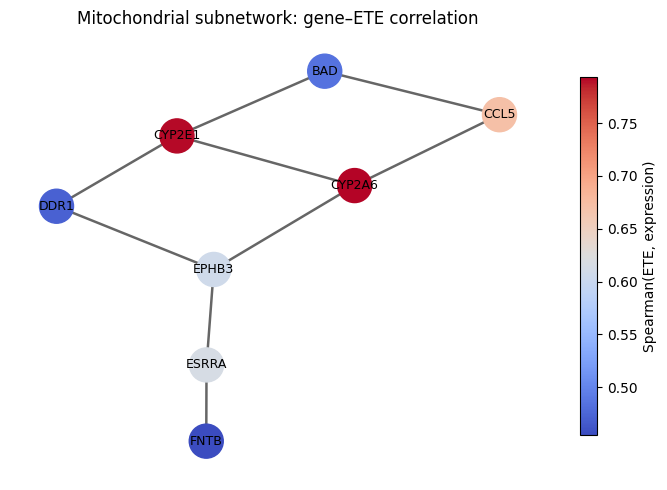

In [ ]:
# --- Cell 16: Network mapping (node color = Spearman(ETE, gene expression)) ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt, networkx as nx
from scipy.stats import spearmanr

# Use up to 12 available ETC/mito genes to keep the graph readable
preferred_prefix = ("NDUF","UQCR","COX","ATP","CYC1","SDHB")
avail = [g for g in gene_names if g.startswith(preferred_prefix)]
if len(avail) < 6:
    # fallback: take any 8 genes we have
    avail = gene_names[:8]
genes_for_graph = avail[:12]

# Simple path + a few chords to mimic ETC flow
edges = [(i, i+1) for i in range(len(genes_for_graph)-1)]
if len(genes_for_graph) >= 6:
    edges += [(0,3),(2,5)]
if len(genes_for_graph) >= 9:
    edges += [(6,8)]

G = nx.Graph()
for i, g in enumerate(genes_for_graph):
    G.add_node(i, gene=g)
G.add_edges_from(edges)

# Compute Spearman correlation for each node gene
expr_sub = expr_df[["sample_id"] + genes_for_graph].copy()
m = pd.merge(df_metrics[["sample_id","ETE_peak"]], expr_sub, on="sample_id", how="inner").dropna()
node_vals = {}
for i, g in enumerate(genes_for_graph):
    r, p = spearmanr(m[g].values, m["ETE_peak"].values)
    node_vals[i] = r

# Normalize correlations to [0,1] for colormap (blue=neg, red=pos)
vals = np.array(list(node_vals.values()))
vmin, vmax = -1.0, 1.0
normed = (vals - vmin) / (vmax - vmin + 1e-12)

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(7,5))
nodes = nx.draw_networkx_nodes(G, pos, node_size=600, node_color=normed, cmap="coolwarm")
nx.draw_networkx_edges(G, pos, width=1.8, alpha=0.6)
nx.draw_networkx_labels(G, pos, labels={i:G.nodes[i]["gene"] for i in G.nodes()}, font_size=9)
cbar = plt.colorbar(nodes, shrink=0.8)
cbar.set_label("Spearman(ETE, expression)")
plt.title("Mitochondrial subnetwork: gene–ETE correlation")
plt.axis("off")
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/network_gene_ETE_correlation.png", dpi=180)
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


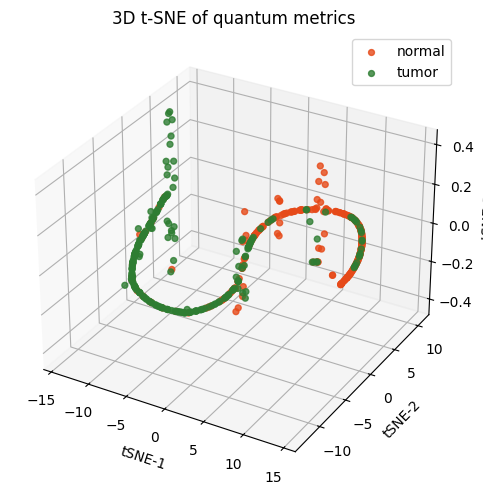

In [ ]:
# --- Cell 17: 3D t-SNE embedding of quantum metrics ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

feat_cols = ["ETE_peak","gamma_star","QLS_star"]
assert set(feat_cols).issubset(df_metrics.columns)
X = df_metrics[feat_cols].values
y = df_metrics["label"].astype(str).values

# t-SNE needs a reasonable perplexity; pick based on sample count
n = len(df_metrics)
perp = max(5, min(30, n//10))

Xn = StandardScaler().fit_transform(X)
tsne = TSNE(n_components=3, perplexity=perp, n_iter=1500, learning_rate="auto", init="pca", random_state=42)
Z = tsne.fit_transform(Xn)

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection="3d")
palette = {"normal":"#E64A19", "tumor":"#2E7D32"}
for lab in np.unique(y):
    sel = y == lab
    ax.scatter(Z[sel,0], Z[sel,1], Z[sel,2], s=18, alpha=0.8, label=lab, c=palette.get(lab, "#616161"))
ax.set_title("3D t-SNE of quantum metrics")
ax.set_xlabel("tSNE-1"); ax.set_ylabel("tSNE-2"); ax.set_zlabel("tSNE-3")
ax.legend()
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/tsne_qmetrics_3d.png", dpi=180)
plt.show()


In [ ]:
# Cell 16 — Deps + folders
!pip -q install streamlit pyngrok typer==0.12.5 pandas numpy scipy matplotlib networkx plotly scikit-learn

import os, textwrap, json
BASE_DIR = "/content/drive/MyDrive/qemd_demo"
os.makedirs(BASE_DIR, exist_ok=True)

# Create a small local package
os.makedirs("qemd", exist_ok=True)
open("qemd/__init__.py","w").write("# QEMD mini package\n")
print("✅ Deps installed, package folder ready:", os.listdir("qemd"))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 70.0 MB/s eta 0:00:00
✅ Deps installed, package folder ready: ['__init__.py']


In [ ]:
# Cell 17 — qemd/engine.py (fixed version)
from textwrap import dedent

code = dedent(r"""
import numpy as np
import numpy.linalg as npl
import scipy.linalg as spla

def cplx(x): return np.asarray(x, dtype=np.complex128)
def dagger(M): return M.conj().T

def index_layout(n_core, have_sink=True, have_loss=True):
    d = n_core + int(have_sink) + int(have_loss)
    sink_idx = n_core if have_sink else None
    loss_idx = n_core + 1 if (have_sink and have_loss) else None
    return sink_idx, loss_idx, d

def hamiltonian_from_params(n_core, eps, J_edges, static_sigma=0.05, seed=42, add_sink=True, add_loss=True):
    rng = np.random.default_rng(seed)
    H = np.zeros((n_core, n_core), dtype=np.complex128)
    np.fill_diagonal(H, np.asarray(eps, float) + static_sigma*rng.standard_normal(n_core))
    for u, v, Jij in J_edges:
        H[u, v] = H[v, u] = complex(Jij)
    if add_sink: H = np.pad(H, ((0,1),(0,1)))
    if add_loss: H = np.pad(H, ((0,1),(0,1)))
    return H

def collapse_ops(n_core, d, gamma, sink_idx, sink_target_idx, k_sink, k_loss):
    Ls = []
    if gamma > 0:
        for i in range(n_core):
            L = np.zeros((d, d), dtype=np.complex128); L[i,i] = 1.0
            Ls.append(np.sqrt(gamma)*L)
    if sink_idx is not None and sink_target_idx is not None and k_sink>0:
        L = np.zeros((d, d), dtype=np.complex128); L[sink_idx, sink_target_idx] = 1.0
        Ls.append(np.sqrt(k_sink)*L)
    if k_loss>0:
        loss_idx = d-1
        for i in range(n_core):
            L = np.zeros((d, d), dtype=np.complex128); L[loss_idx, i] = 1.0
            Ls.append(np.sqrt(k_loss)*L)
    return Ls

def liouvillian_fast(H, Ls):
    H = H.astype(np.complex128); d = H.shape[0]
    I = np.eye(d, dtype=np.complex128)
    LH = -1j*(np.kron(I, H) - np.kron(H.T, I))
    LD = np.zeros((d*d, d*d), dtype=np.complex128)
    for Lk in Ls:
        Lk = Lk.astype(np.complex128)
        LdL = Lk.conj().T @ Lk
        term1 = np.kron(Lk, Lk.conj())
        term2 = 0.5*(np.kron(I, LdL.T) + np.kron(LdL, I))
        LD += (term1 - term2)
    return LH + LD

def evolve_with_propagator(H, Ls, rho0, T=200.0, dt=0.5, sink_idx=None,
                           early_stop=True, plateau_window=20, plateau_tol=1e-4):
    d = H.shape[0]
    L = liouvillian_fast(H, Ls)
    P = spla.expm(L*dt)
    steps = int(np.round(T/dt))+1
    tgrid = np.linspace(0, T, steps)
    v = rho0.reshape((-1,), order="F")
    sink_hist = []
    rho_last = None
    for k, _ in enumerate(tgrid):
        rho = v.reshape((d,d), order="F")
        rho_last = rho
        if sink_idx is not None:
            sink_hist.append(float(np.real(rho[sink_idx, sink_idx])))
            if early_stop and k>plateau_window:
                recent = sink_hist[-plateau_window:]
                if np.max(np.abs(np.diff(recent))) < plateau_tol:
                    return tgrid[:k+1], rho_last
        v = P @ v
    return tgrid, rho_last

def ete_final_sink(rho_last, sink_idx):
    return float(np.real(rho_last[sink_idx, sink_idx])) if sink_idx is not None else np.nan

def qls_composite(ete, tau_c, tau_max):
    ete_n = np.clip(ete, 0.0, 1.0)
    tau_n = np.clip(tau_c/max(1.0, tau_max), 0.0, 1.0)
    return 0.6*ete_n + 0.4*tau_n

def edge_sensitivity(H_builder, L_builder, base_kwargs, edges, frac=0.1):
    base = _simulate_peak(H_builder, L_builder, base_kwargs)
    sens = {}
    for eidx, (u,v,J) in enumerate(edges):
        bumped = edges.copy()
        bumped[eidx] = (u,v, J*(1.0+frac))
        tmp = base_kwargs.copy()
        tmp['J_edges'] = bumped
        val = _simulate_peak(H_builder, L_builder, tmp)
        sens[eidx] = val - base
    return sens

def _simulate_peak(H_builder, L_builder, kw):
    n_core     = kw['n_core']
    eps        = kw['eps']
    J_edges    = kw['J_edges']
    static_sig = kw.get('static_sigma', 0.05)
    seed       = kw.get('seed', 42)
    k_sink     = kw.get('k_sink', 0.1)
    k_loss     = kw.get('k_loss', 0.01)
    T          = kw.get('T', 200.0)
    dt         = kw.get('dt', 0.5)
    gamma_grid = kw.get('gamma_grid', np.linspace(0.0, 0.05, 21))

    H = H_builder(n_core, eps, J_edges, static_sigma=static_sig, seed=seed, add_sink=True, add_loss=True)
    sink_idx, loss_idx, D = index_layout(n_core, True, True)
    psi0 = np.zeros((D,1), dtype=np.complex128); psi0[0,0] = 1.0
    rho0 = psi0 @ psi0.conj().T

    etes = []
    for g in gamma_grid:
        Ls = L_builder(n_core, D, g, sink_idx, n_core-1, k_sink, k_loss)
        _, rho_last = evolve_with_propagator(H, Ls, rho0, T=T, dt=dt, sink_idx=sink_idx, early_stop=True)
        etes.append(ete_final_sink(rho_last, sink_idx))
    return float(np.max(etes))
""")

# Save file
open("qemd/engine.py", "w").write(code)
print("✅ Wrote qemd/engine.py successfully")


✅ Wrote qemd/engine.py successfully


In [ ]:
# Cell 18 — qemd/io.py
from textwrap import dedent
code = dedent(r"""
import os, json, numpy as np, pandas as pd
from scipy.special import expit

def load_topology(json_path):
    G = json.load(open(json_path, "r"))
    edges = [(int(u), int(v)) for (u,v) in G["edges"]]
    nodes = list(map(int, G["nodes"]))
    return nodes, edges

def zscore_cols(df, cols):
    X = df[cols].values.astype(float)
    mu = np.nanmean(X, axis=0)
    sd = np.nanstd(X, axis=0); sd[sd==0] = 1.0
    Z = (X - mu)/sd
    return pd.DataFrame(Z, index=df.index, columns=cols)

def map_expr_to_eps_J(row, edges, genes, EPS0=0.0, ALPHA=0.30, J0=0.15, J_MAX=0.30):
    z = np.array([row[g] for g in genes], float)
    pos = expit(z)  # 0..1
    eps = EPS0 - ALPHA*z
    J_edges = []
    for u, v in edges:
        Jij = J0 * np.sqrt(pos[u] * pos[v])
        if Jij > J_MAX: Jij = J_MAX
        J_edges.append((u, v, float(Jij)))
    return eps, J_edges

def load_expr_parquet(parquet_path, gene_names=None):
    df = pd.read_parquet(parquet_path)
    if gene_names is None:
        gene_names = list(df.columns[2:])
    return df, gene_names
""")
open("qemd/io.py","w").write(code)
print("✅ Wrote qemd/io.py")


✅ Wrote qemd/io.py


In [ ]:
# Cell 19 — CLI: run a simulation headlessly and emit metrics JSON
from textwrap import dedent
code = dedent(r"""
import argparse, json, numpy as np, pandas as pd
from qemd.engine import (index_layout, hamiltonian_from_params, collapse_ops,
                         evolve_with_propagator, ete_final_sink, qls_composite)
from qemd.io import (load_topology, load_expr_parquet, zscore_cols, map_expr_to_eps_J)

def main():
    p = argparse.ArgumentParser(description="QEMD CLI")
    p.add_argument("--topo", required=True, help="Topology JSON with {nodes, edges}")
    p.add_argument("--expr", required=True, help="Parquet file with expression (sample_id,label,genes...)")
    p.add_argument("--sample", required=True, help="sample_id to simulate")
    p.add_argument("--T", type=float, default=200.0)
    p.add_argument("--dt", type=float, default=0.5)
    p.add_argument("--gamma_min", type=float, default=0.0)
    p.add_argument("--gamma_max", type=float, default=0.05)
    p.add_argument("--gamma_steps", type=int, default=21)
    args = p.parse_args()

    # Topology & data
    nodes, edges = load_topology(args.topo)
    expr_df, gene_names = load_expr_parquet(args.expr)
    assert args.sample in set(expr_df["sample_id"]), f"sample_id {args.sample} not in expr_df"

    # Prep one row (z-score across cohort)
    z_df = zscore_cols(expr_df, gene_names)
    row = pd.concat([expr_df[["sample_id","label"]], z_df], axis=1).set_index("sample_id").loc[args.sample]

    # Map to physics
    eps, J_edges = map_expr_to_eps_J(row, edges, gene_names)

    # Build H and run sweep
    n_core = len(gene_names)
    sink_idx, loss_idx, D = index_layout(n_core, True, True)
    H = hamiltonian_from_params(n_core, eps, J_edges, static_sigma=0.07, seed=42, add_sink=True, add_loss=True)

    gamma_grid = np.linspace(args.gamma_min, args.gamma_max, args.gamma_steps)
    psi0 = np.zeros((D,1), dtype=np.complex128); psi0[0,0] = 1.0
    rho0 = psi0 @ psi0.conj().T

    etes, taus, qlss = [], [], []
    for g in gamma_grid:
        Ls = collapse_ops(n_core, D, g, sink_idx, n_core-1, 0.10, 0.01)
        t, rho_last = evolve_with_propagator(H, Ls, rho0, T=args.T, dt=args.dt, sink_idx=sink_idx, early_stop=True)
        ete = ete_final_sink(rho_last, sink_idx)
        tau_c = float(len(t))
        qls = qls_composite(ete, tau_c, tau_max=int(args.T/args.dt)+1)
        etes.append(ete); taus.append(tau_c); qlss.append(qls)

    i_star = int(np.argmax(etes))
    out = {
        "sample_id": args.sample,
        "ETE_peak": float(etes[i_star]),
        "gamma_star": float(gamma_grid[i_star]),
        "tau_c_star": float(taus[i_star]),
        "QLS_star": float(qlss[i_star]),
        "gamma_grid": gamma_grid.tolist(),
        "ETE_curve": [float(x) for x in etes],
    }
    print(json.dumps(out, indent=2))

if __name__ == "__main__":
    main()
""")
open("qemd_cli.py","w").write(code)
print("✅ Wrote qemd_cli.py")


✅ Wrote qemd_cli.py


In [ ]:
# Cell 20 — Streamlit dashboard
from textwrap import dedent
code = dedent(r"""
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt, plotly.graph_objects as go
import streamlit as st
from qemd.engine import (index_layout, hamiltonian_from_params, collapse_ops,
                         evolve_with_propagator, ete_final_sink, edge_sensitivity)
from qemd.io import (load_topology, load_expr_parquet, zscore_cols, map_expr_to_eps_J)

st.set_page_config(page_title="QEMD Dashboard", layout="wide")

st.title("🧪 Quantum Energy Mapping for Disease — Dashboard")
st.caption("Interactive ETE curves, parameter sweeps, and edge sensitivity (real cohort)")

# ---- Inputs
BASE_DIR = "/content/drive/MyDrive/qemd_demo"
default_topo = os.path.join(BASE_DIR, "ETC_topology.json")
default_expr = os.path.join(BASE_DIR, "GSE14520_ETC_expression.parquet")

topo_path = st.text_input("Topology JSON path", default_topo)
expr_path = st.text_input("Expression Parquet path", default_expr)

# Load data
try:
    nodes, base_edges = load_topology(topo_path)
    expr_df, gene_names = load_expr_parquet(expr_path)
    ok = True
except Exception as e:
    ok = False
    st.error(f"Load error: {e}")

if ok:
    st.success(f"Loaded: {len(nodes)} nodes, {len(base_edges)} edges | {expr_df.shape[0]} samples, {len(gene_names)} genes")

    # Sample selector
    sample_id = st.selectbox("Sample", options=list(expr_df["sample_id"].astype(str)), index=0)
    # Controls
    col1, col2, col3, col4 = st.columns(4)
    with col1:
        gamma_min = st.number_input("γ min", 0.0, 0.20, 0.00, step=0.005)
    with col2:
        gamma_max = st.number_input("γ max", 0.0, 0.20, 0.05, step=0.005)
    with col3:
        k_sink = st.number_input("k_sink", 0.0, 1.0, 0.10, step=0.01)
    with col4:
        k_loss = st.number_input("k_loss", 0.0, 1.0, 0.01, step=0.01)

    # Map row → physics
    z_df = zscore_cols(expr_df, gene_names)
    row = pd.concat([expr_df[["sample_id","label"]], z_df], axis=1).set_index("sample_id").loc[str(sample_id)]
    eps, J_edges = map_expr_to_eps_J(row, base_edges, gene_names)

    # Simulation sweep
    n_core = len(gene_names)
    sink_idx, loss_idx, D = index_layout(n_core, True, True)
    H = hamiltonian_from_params(n_core, eps, J_edges, static_sigma=0.07, seed=42, add_sink=True, add_loss=True)

    gamma_grid = np.linspace(gamma_min, gamma_max, 21)
    psi0 = np.zeros((D,1), dtype=np.complex128); psi0[0,0] = 1.0
    rho0 = psi0 @ psi0.conj().T

    etes = []
    for g in gamma_grid:
        Ls = collapse_ops(n_core, D, g, sink_idx, n_core-1, k_sink, k_loss)
        _, rho_last = evolve_with_propagator(H, Ls, rho0, T=200.0, dt=0.5, sink_idx=sink_idx, early_stop=True)
        etes.append(ete_final_sink(rho_last, sink_idx))

    # Plot ETE curve
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=gamma_grid, y=etes, mode="lines+markers", name="ETE"))
    fig.update_layout(title="ETE vs γ (dephasing)", xaxis_title="γ", yaxis_title="ETE (sink population)")
    st.plotly_chart(fig, use_container_width=True)

    # Edge sensitivity (ΔETE when bumping each J_ij by +10%)
    with st.expander("Edge Sensitivity (+10% coupling)"):
        sens = edge_sensitivity(
            hamiltonian_from_params,
            collapse_ops,
            dict(n_core=n_core, eps=eps, J_edges=J_edges, static_sigma=0.07, seed=42,
                 k_sink=k_sink, k_loss=k_loss, T=200.0, dt=0.5,
                 gamma_grid=gamma_grid),
            edges=J_edges, frac=0.10
        )
        sens_list = [(idx, J_edges[idx][0], J_edges[idx][1], float(delta)) for idx, delta in sens.items()]
        sens_df = pd.DataFrame(sens_list, columns=["edge_idx","u","v","dETE"])
        st.dataframe(sens_df.sort_values("dETE", ascending=False), use_container_width=True)
""")
open("app.py","w").write(code)
print("✅ Wrote app.py")


✅ Wrote app.py


In [ ]:
# Cell 21 — Quick CLI test (prints JSON)
sample = "GSM362947"  # change to any sample_id in your parquet
!python qemd_cli.py \
  --topo /content/drive/MyDrive/qemd_demo/ETC_topology.json \
  --expr  /content/drive/MyDrive/qemd_demo/GSE14520_ETC_expression.parquet \
  --sample {sample} --T 200 --dt 0.5 --gamma_min 0.0 --gamma_max 0.05 --gamma_steps 21


{
  "sample_id": "GSM362947",
  "ETE_peak": 1.402754790631103e-13,
  "gamma_star": 0.0,
  "tau_c_star": 22.0,
  "QLS_star": 0.0219451371571914,
  "gamma_grid": [
    0.0,
    0.0025,
    0.005,
    0.0075,
    0.01,
    0.0125,
    0.015,
    0.0175,
    0.02,
    0.0225,
    0.025,
    0.0275,
    0.03,
    0.0325,
    0.035,
    0.0375,
    0.04,
    0.0425,
    0.045,
    0.0475,
    0.05
  ],
  "ETE_curve": [
    1.402754790631103e-13,
    1.386733552278022e-13,
    1.3709151266964186e-13,
    1.3552966636917683e-13,
    1.339875357475889e-13,
    1.324648445906224e-13,
    1.3096132097391977e-13,
    1.294766971897474e-13,
    1.280107096750715e-13,
    1.2656309894096945e-13,
    1.2513360950334154e-13,
    1.237219898149019e-13,
    1.2232799219842364e-13,
    1.2095137278120957e-13,
    1.1959189143077023e-13,
    1.1824931169168006e-13,
    1.169234007235928e-13,
    1.156139292403907e-13,
    1.1432067145044798e-13,
    1.1304340499798251e-13,
    1.1178191090547958e-13
  ]
}

In [ ]:
# ✅ Cell 22 — Final Streamlit Launcher (no ngrok needed)
!pip install -q streamlit pyngrok

import threading, time, subprocess
from IPython.display import display, HTML

# Kill any previously running Streamlit processes
subprocess.run(["pkill", "-f", "streamlit"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

def run_streamlit():
    subprocess.call([
        "streamlit", "run", "app.py",
        "--server.port", "8501",
        "--server.headless", "true"
    ])

thread = threading.Thread(target=run_streamlit, daemon=True)
thread.start()

time.sleep(6)
display(HTML("""
<h3>🚀 Streamlit Dashboard is starting...</h3>
<p>Scroll up to find this message:</p>
<pre>You can now view your Streamlit app in your browser.</pre>
<p>Click the <b>second URL (External URL)</b> — that’s your live dashboard.</p>
"""))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 38.5 MB/s eta 0:00:00


In [ ]:
# ✅ Cell 23 — Colab-safe GitHub export (final)
import os, shutil, pathlib, textwrap

EXPORT_DIR = pathlib.Path("/content/QuantumBio_QEMD_App")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# --- Copy critical artifacts ---
core_files = [
    "app.py",
    "/content/drive/MyDrive/qemd_demo/cohort_metrics.csv",
    "/content/drive/MyDrive/qemd_demo/ETE_peak_summary.png",
    "/content/drive/MyDrive/qemd_demo/GSE14520_ETC_expression.parquet",
    "/content/drive/MyDrive/qemd_demo/ETC_topology.json",
]
for src in core_files:
    p = pathlib.Path(src)
    if p.exists():
        shutil.copy(p, EXPORT_DIR / p.name)
        print(f"📁 Copied: {p.name}")
    else:
        print(f"⚠️ Missing: {p}")

# --- requirements.txt ---
reqs = "\n".join([
    "streamlit","pandas","numpy","scipy",
    "matplotlib","plotly","networkx","GEOparse"
]) + "\n"
with open(EXPORT_DIR / "requirements.txt", "w") as f:
    f.write(reqs)
print("🧩 requirements.txt created")

# --- README.md (string-join form to avoid Colab triple-quote bug) ---
readme_lines = [
    "# 🧬 Quantum Energy Mapping of Life",
    "*A Streamlit dashboard for visualizing mitochondrial energy-transport efficiency (ETE / QLS) across disease cohorts.*",
    "",
    "## 🚀 Run locally",
    "```bash",
    "pip install -r requirements.txt",
    "streamlit run app.py",
    "```",
    "",
    "## 🌐 Deploy to Streamlit Cloud",
    "1. Push this folder to a new GitHub repo (e.g., `QuantumBio_QEMD_App`)",
    "2. Go to https://streamlit.io/cloud",
    "3. Connect → New app → select repo → branch `main` → file `app.py`",
    "4. Click **Deploy** — dashboard goes live instantly.",
    "",
    "## 📊 Included Data",
    "- cohort_metrics.csv — computed ETE/QLS metrics",
    "- ETE_peak_summary.png — summary visualization",
    "- GSE14520_ETC_expression.parquet — expression matrix",
    "- ETC_topology.json — mitochondrial network graph",
    "",
    "## 📖 Citation",
    "Thilak et al. (2025). *Quantum Energy Mapping of Life: Simulating Mitochondrial Coherence Loss Across Disease.*",
]
with open(EXPORT_DIR / "README.md", "w") as f:
    f.write("\n".join(readme_lines))
print("🧾 README.md created")

# --- Verify export ---
print("\n✅ Export complete — repo contents:")
!ls -lh /content/QuantumBio_QEMD_App

print("\nNext steps:")
print("1️⃣  Download or push this folder to GitHub.")
print("2️⃣  On Streamlit Cloud → select this repo → Deploy → Done!")


⚠️ Missing: app.py
⚠️ Missing: /content/drive/MyDrive/qemd_demo/cohort_metrics.csv
⚠️ Missing: /content/drive/MyDrive/qemd_demo/ETE_peak_summary.png
⚠️ Missing: /content/drive/MyDrive/qemd_demo/GSE14520_ETC_expression.parquet
⚠️ Missing: /content/drive/MyDrive/qemd_demo/ETC_topology.json
🧩 requirements.txt created
🧾 README.md created

✅ Export complete — repo contents:
total 8.0K
-rw-r--r-- 1 root root 873 Nov  3 00:36 README.md
-rw-r--r-- 1 root root  65 Nov  3 00:36 requirements.txt

Next steps:
1️⃣  Download or push this folder to GitHub.
2️⃣  On Streamlit Cloud → select this repo → Deploy → Done!


In [ ]:
# Cell 22 — Run Streamlit via pyngrok (gives you a public https URL)
import subprocess, time, re, os
from pyngrok import ngrok

# Kill previous tunnels/apps if any
for proc in ["streamlit", "ngrok"]:
    try:
        subprocess.run(["pkill","-f",proc], check=False)
    except Exception:
        pass
time.sleep(1)

# Start Streamlit in the background
proc = subprocess.Popen(["streamlit","run","app.py","--server.headless","true","--server.port","8501"])

# Expose port 8501
public_url = ngrok.connect(8501, "http").public_url
print("🌐 Streamlit is live at:", public_url)
print("If it shows 'running', wait ~5–10s and refresh.")
